### Video Object Recoginition


For this project I will be using Tensorflow, and __[Open CV](https://opencv.org)__ to identify open images in videos. I will read in a video, feed each frame through a pretrained TensorFlow model and then output a video with the labels of object the model detects. The Tensoflow model I am using is pretrained from __[SSD MobileNet V1 Coco](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md)__ I used a a video file from __[Pexels.com](https://www.pexels.com/video/traffic-flow-in-the-highway-2103099/)__ for to test the model 

The first step is to import the necessary libaries and read in the video file (reduced from one minute to three seconds long)

![SegmentLocal](cars.gif "segment")


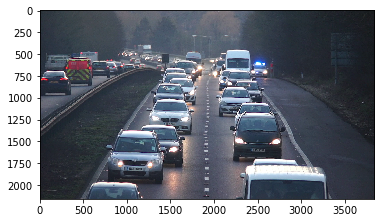

In [3]:
import cv2 as cv
import matplotlib.pyplot as plt

#reading in video file 
cap = cv.VideoCapture('cars-short.mp4')

ret, frame = cap.read()

#Looking at the first frame of the video and changing the color of the video to regular RGB values
frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

#Checking the first frame of the video
plt.imshow(frame)

In [4]:
#Checking the size of each frame we are reading into our model

original_size = frame.shape

original_size


(2160, 3840, 3)

Below is pseudocode to help figure out what has to happen next so we can feed video frames into a pretrained TensorFlow model and output an mp4 file with labels and bounding boxes

1. We need to read a mp4 video and read it frame by frame, creating loop
2. The model expects a 300X300 size image, we need to scale each frame to fit the model. Each bounding box the model outputs need to be rescaled to original frame size
3. We will need to write labels and bounding boxes onto original framframe
4. For each frame, we will use open CV to write new mp4 file
5. Final output file should be mp4 file with scaled bounding boxes and labels next to each image.  

Below we are going to be loading our label data and training data, both of which come from __[TensorFlow Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md)__

In [21]:
import tensorflow as tf

#loading label from the trained Tensorflow model https://github.com/nightrome/cocostuff/blob/master/labels.txt
with open('./labels.txt', 'r') as f:
    labels = f.readlines()

# Remove the indexes from labels
labels = list(map(lambda x: x[x.index(' '):], labels))

# Strip leading and trailing whitespace from label
labels = list(map(lambda x: x.strip(), labels))

#Check to make sure our labels were properly uploaded
print("There are", len(labels), "labels")
print("The label at 50 is:", labels[50])

There are 183 labels
The label at 50 is: spoon


In [88]:
#loading the trained tensorflow model by reading the file in binary format and then parsing it into a GraphDef object
with tf.gfile.FastGFile('./frozen_inference_graph.pb','rb') as f:
  graph_def = tf.GraphDef()
  graph_def.ParseFromString(f.read())
    

Now the fun part, we are going to feed every of our video into our tensorflow model, have the model detect the object in the frame, draw a bounding box and label text on each frame, and then output a final mp4 file. Note, before we load each image into our tensorflow model as a 300X300 pixel image. 

In [89]:
#creating a function that labels the frame, draws a bounding box around object and writes label next to each object it detects

def labelImage(frame, sess):
    
    height = frame.shape[0]
    width = frame.shape[1]
    
    #rescaling frame for our model
    frame_scaled = cv.resize(frame, (300, 300))

    detections = sess.run([
      sess.graph.get_tensor_by_name('num_detections:0'),    # [0] in detections
      sess.graph.get_tensor_by_name('detection_scores:0'),  # [1] in detections
      sess.graph.get_tensor_by_name('detection_boxes:0'),   # [2] in detections
      sess.graph.get_tensor_by_name('detection_classes:0'), # [3] in detections
    ], feed_dict={
      'image_tensor:0': frame_scaled.reshape(1, frame_scaled.shape[0], frame_scaled.shape[1], 3)
    })

    # num_detections:0
    detection_count = int(detections[0][0])
    threshold = 0.2
   
    for i in range(detection_count):
        # detection_scores:0
        confidence_score = detections[1][0][i]
        
        if confidence_score > threshold:

        # multiplying detection boxes by original frame dimensions so we can properly scale bounding boxes
            box = detections[2][0][i]
            box_top = int(box[0]*height)
            box_left = int(box[1]*width)
            box_bottom = int(box[2]*height)
            box_right = int(box[3]*width)

            # detection_classes:0
            label_id = int(detections[3][0][i])
            label_name = labels[label_id]

            scale = 8
            thickness = 20

            #Adding text on image with lable
            cv.putText(frame, label_name, (box_left, box_top), cv.FONT_HERSHEY_SIMPLEX, scale, [0, 255, 0], thickness)

            #Adding bounding box and filled box to better see lable
            cv.rectangle(frame, (box_left, box_top), (box_right, box_bottom), (255, 0, 0), thickness)
           
        else: 
            break
    return frame


Lets feed it in a test image to make sure it works

<IPython.core.display.Javascript object>


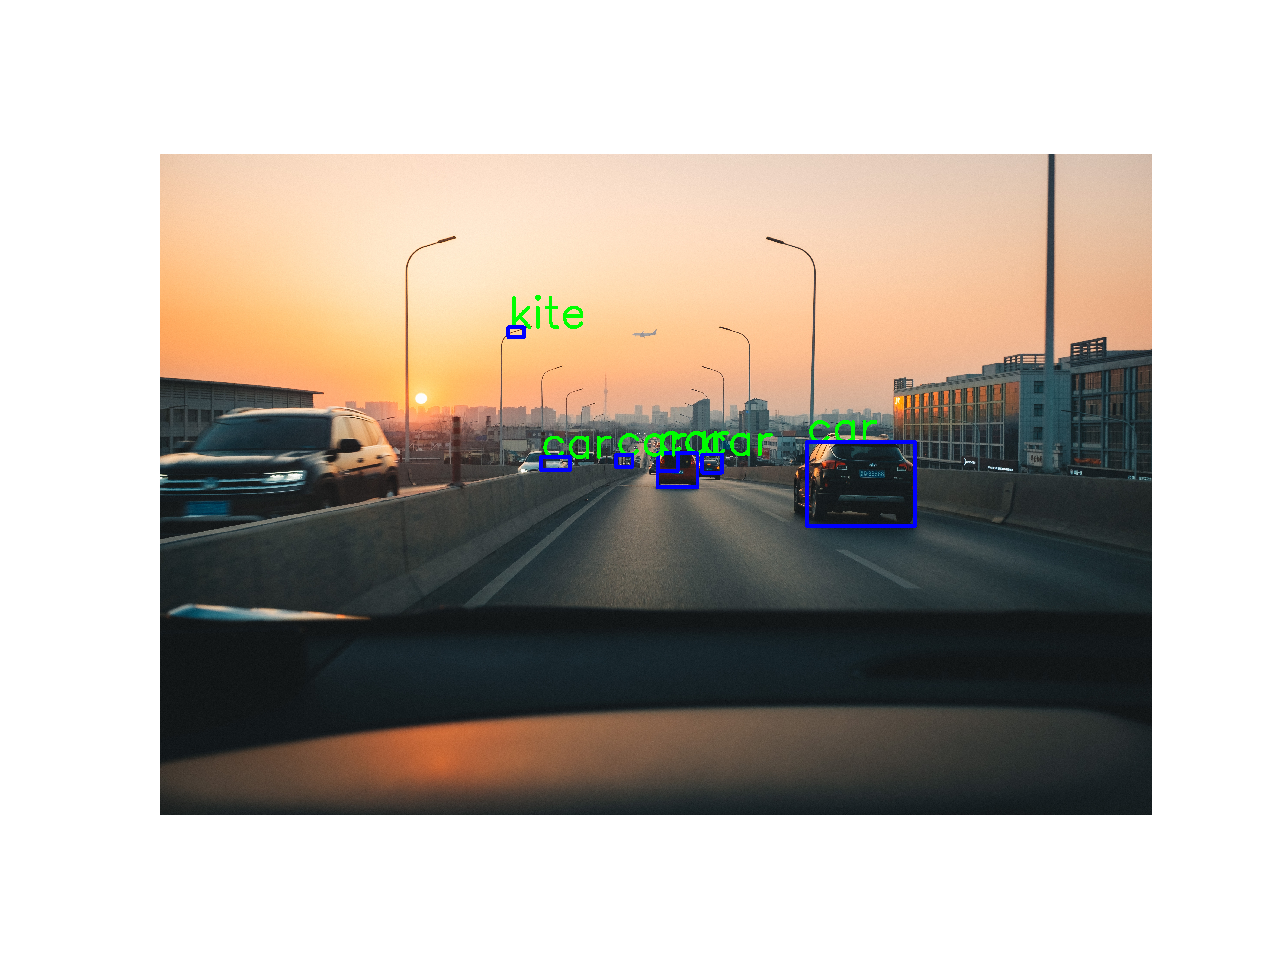

In [91]:
%matplotlib notebook

with tf.Session() as sess:
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    
    image = cv.imread('traffic.jpg')
    new_image = labelImage(image, sess)
    new_image = cv.cvtColor(new_image, cv.COLOR_BGR2RGB)
    plt.imshow(new_image)
    plt.grid(False)
    plt.axis('off')
    plt.show()

Cool beans (also- kite lol)! Next, we need to write a function that will split our video into individual frames, then feed each frame into our model, and finally write a new mp4 file with the boxes and labels.

In [83]:
def readVideo(filename, output, frames):
    cap = cv.VideoCapture(filename)

    height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    fps = cap.get(cv.CAP_PROP_FPS)
    total_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    
    fourcc = cv.VideoWriter_fourcc(*'MP4V')
    output = cv.VideoWriter(output, fourcc, fps, (width, height))

    with tf.Session() as sess:
        sess.graph.as_default()
        tf.import_graph_def(graph_def, name='')
        
        #only going to fifth last frame or else getting output error
        for i in range(0, total_frames-5, frames):
            cap.set(cv.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if not ret:
                raise Exception("Problem reading frame", i, " from video")
            else:
                result = labelImage(frame, sess)
                output.write(result)
    
    cap.release()
    output.release()
    


Now lets pass in our video involving cars crusing down the highway and output file to our directory

In [86]:
readVideo('cars-short.mp4', 'cars-short-labels.mp4', 1)


And voilà- our labeled video was created successfully

![SegmentLocal](carslabled.gif "segment")